In [1]:
# import the libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from pathlib import Path
import numpy as np
import matplotlib

In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [6]:
# Select SS316 stainless steel and sub-sized samples
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [7]:
# check these columns that have noisy data. 
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [8]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [9]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [10]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [11]:
# Drop the columns that don't have  enough data records.

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment',  'Specimen Size Type',
                                      'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Ultimate Tensile Strength (MPa)',
                                       'Yield Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [12]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 21 to 703
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                86 non-null     object 
 1   C (wt.%)                      86 non-null     float64
 2   Si (wt.%)                     86 non-null     float64
 3   Mn (wt.%)                     86 non-null     float64
 4   P (wt.%)                      86 non-null     float64
 5   S (wt.%)                      86 non-null     float64
 6   Ni (wt.%)                     86 non-null     float64
 7   Cr (wt.%)                     86 non-null     float64
 8   Mo (wt.%)                     86 non-null     float64
 9   Al (wt.%)                     86 non-null     float64
 10  N (wt.%)                      86 non-null     float64
 11  Ti (wt.%)                     86 non-null     float64
 12  Fe (wt.%)                     86 non-null     float64
 13  Nb (wt.%) 

In [13]:
# sort the data by UE values
tensile_df = tensile_df.sort_values(by='Uniform Elongation (%)').reset_index(drop=True)


In [14]:
# Select columns for modeling.

input_features_df =  tensile_df.drop(columns=['Uniform Elongation (%)'])

In [15]:
# Encode the categorical columns
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [16]:
# make sure all the input features data is float data type
input_features_df = input_features_df.astype('float')

In [17]:
# define input features and input targets
features = input_features_df
targets = tensile_df['Uniform Elongation (%)']

In [18]:
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

q: 0.025 | pearsonr: 0.9657012874599361
q: 0.5 | pearsonr: 0.985918219259653
q: 0.975 | pearsonr: 0.8979071195916621
Pearson CC: 0.985918219259653
R2 score: 0.972005744216961
RMSE: 2.8883696417321727
MAE: 2.065505549680278
Coverage: 100.0
Interval Width: 41.25070264860351
Composite Metric: 0.7560605028265734


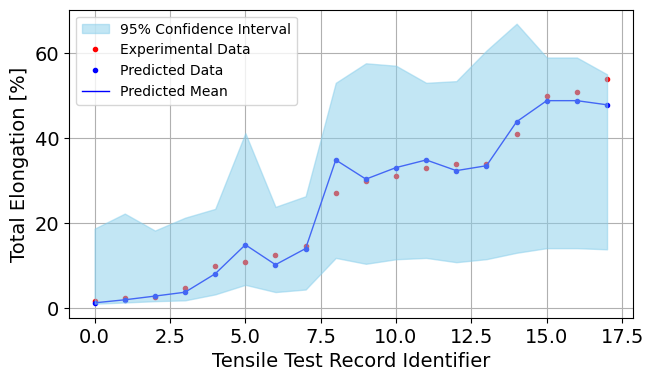

********************
q: 0.025 | pearsonr: 0.9033434578715791
q: 0.5 | pearsonr: 0.9169365176768903
q: 0.975 | pearsonr: 0.97588332303265
Pearson CC: 0.9169365176768903
R2 score: 0.8100717508904527
RMSE: 9.777334274271412
MAE: 5.4933707442226085
Coverage: 76.47058823529412
Interval Width: 22.496055999471643
Composite Metric: 0.5846424708718609


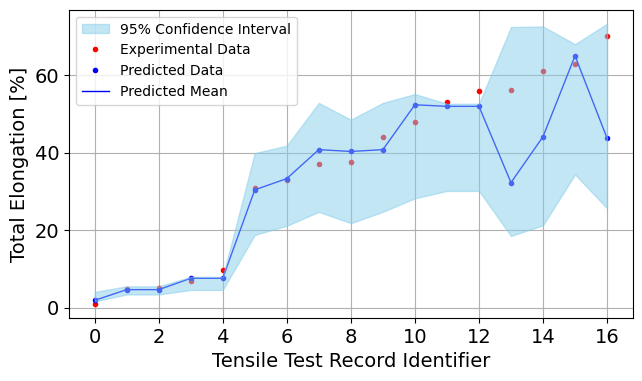

********************
q: 0.025 | pearsonr: 0.9352128890329623
q: 0.5 | pearsonr: 0.9442581357362627
q: 0.975 | pearsonr: 0.9304875125196665
Pearson CC: 0.9442581357362627
R2 score: 0.8528969148691188
RMSE: 8.261784587277281
MAE: 3.211545222156435
Coverage: 41.1764705882353
Interval Width: 4.679837302730354
Composite Metric: 0.3622441899663833


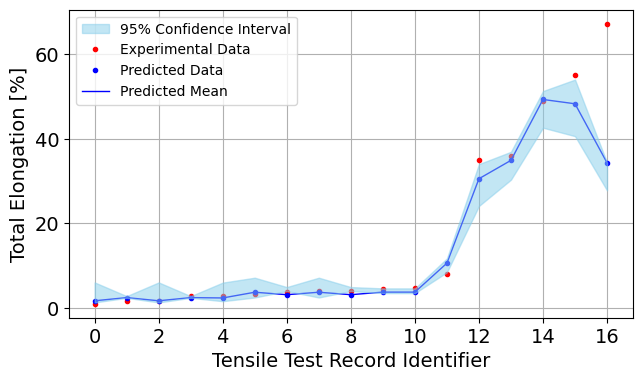

********************
q: 0.025 | pearsonr: 0.9107374715146989
q: 0.5 | pearsonr: 0.9420764157416085
q: 0.975 | pearsonr: 0.8159390733658098
Pearson CC: 0.9420764157416085
R2 score: 0.8590977993044162
RMSE: 6.431948875298446
MAE: 3.2060531023031644
Coverage: 88.23529411764707
Interval Width: 24.937445233449147
Composite Metric: 0.6717897905556085


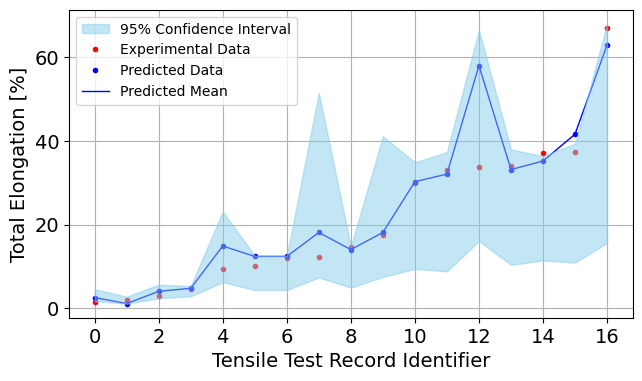

********************
q: 0.025 | pearsonr: 0.9280989943685938
q: 0.5 | pearsonr: 0.9627191473607094
q: 0.975 | pearsonr: 0.8937812672653421
Pearson CC: 0.9627191473607094
R2 score: 0.868069875060707
RMSE: 7.699894717571908
MAE: 5.010970049870413
Coverage: 47.05882352941177
Interval Width: 24.97313685880448
Composite Metric: 0.36295193328554004


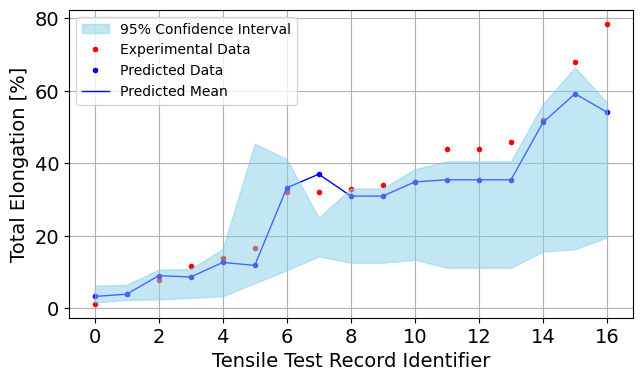

********************


In [19]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

quantiles = [0.025, 0.5, 0.975]

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
                X_train, X_test = features.iloc[tr], features.iloc[ts]
                scale = StandardScaler()
                X_train = scale.fit_transform(X_train)
                X_test = scale.transform(X_test)
                y_train, y_test = targets.iloc[tr], targets.iloc[ts]
                X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.1, random_state=42)

                for q in quantiles:
                        parameters = {'loss_function': 'Quantile:alpha={:0.2f}'.format(q),
                                'num_boost_round': 20000}
                        model = CatBoostRegressor(**parameters)
                        model.fit(X_train, np.log(y_train),
                                eval_set=[(X_val, np.log(y_val))],
                                early_stopping_rounds=20,
                                verbose=False)
                        y_pred = np.exp(model.predict(X_test))
                        print(f'q: {q} | pearsonr: {pearsonr(y_test, y_pred)[0]}')
                        if q==0.025:
                           y_low = y_pred
                        elif q==0.5:
                                y_median = y_pred
                        elif q==0.975:
                               y_high = y_pred

                # Plot the predictions
                iteration_list = [i for i in range(len(y_test))]

                PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_median))[0]
                R2_score[j, i] = r2_score(y_test, y_median)
                RMSE[j, i] = np.sqrt(mean_squared_error(y_test, y_median))
                MAE[j, i] = np.mean(abs(y_median-np.array(y_test)))

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {RMSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')

                test_coverage[j, i] = coverage(y_test, y_low, y_high)
                print(f'Coverage: {test_coverage[j, i]}')

                # Prediction interval width
                median_interval_width[j, i] = np.median(y_high - y_low)
                print(f'Interval Width: {median_interval_width[j, i]}')

                # Composite metric that combines the coverage and the invers of interval width
                composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
                print(f'Composite Metric: {composite_metric[j, i]}')


                            # Plot the predictions
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

                ## Uncertainty quantification plot
                ax[0].fill_between(iteration_list, y_low, y_high, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
                ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
                ax[0].plot(iteration_list, y_median, 'bo', markersize=3, label="Predicted Data")
                ax[0].plot(iteration_list, y_median, '-', linewidth=1, color="blue", label="Predicted Mean")
                ax[0].legend(fontsize=10, frameon=True, loc="upper left")
                ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
                ax[0].set_ylabel("Total Elongation [%]", fontsize=14)
                ax[0].tick_params(axis='both', which='major', labelsize=14)
                ax[0].grid(True, which='major', linestyle='-', linewidth='0.8')


                fig.delaxes(ax[1])
                plt.show()
                print(20*'*')


In [20]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.985918,0.972006,2.888370,2.065506,100.000000
1,0.916937,0.810072,9.777334,5.493371,76.470588
2,0.944258,0.852897,8.261785,3.211545,41.176471
3,0.942076,0.859098,6.431949,3.206053,88.235294
4,0.962719,0.868070,7.699895,5.010970,47.058824


In [21]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.950382,0.022979,0.872428,0.053632,7.011866,2.32478,3.797489,1.268183,70.588235,22.933634


In [22]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten()},index=None)
df3

,Coverage,Interval Width
0,100.000000,41.250703
1,76.470588,22.496056
2,41.176471,4.679837
3,88.235294,24.937445
4,47.058824,24.973137


In [23]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)


# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   },index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std
0,70.588235,22.933634,23.667436,11.613699
